In [1]:
import numpy as np
import pandas as pd
import sys
import os

import pickle
from collections import defaultdict
from tqdm import tqdm
from glob import glob
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
from sklearn.utils import resample

import matplotlib.pyplot as plt
import matplotlib

import scipy.stats

sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 
from misc import model_alias, model_colors, rna_models

In [2]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

In [3]:
def read_fasta(fasta):

    seqs = defaultdict(str)
    
    with open(fasta, 'r') as f:
        for line in f:
            if line.startswith('>'):
                seq_name = line[1:].rstrip()
            else:
                seqs[seq_name] += line.rstrip().upper()
    return seqs

def reverse_complement(seq):
    '''
    Take sequence reverse complement
    '''
    compl_dict = {'A':'T', 'C':'G', 'G':'C', 'T':'A','a':'t', 'c':'g', 'g':'c', 't':'a'}
    compl_seq = ''.join([compl_dict.get(x,x) for x in seq])
    rev_seq = compl_seq[::-1]
    return rev_seq

def calculate_auc(y_true, y_pred, seed):
    y_pred_resampled, y_true_resampled = resample(y_pred, y_true, random_state=seed)
    auc = roc_auc_score(y_true_resampled, y_pred_resampled)
    return auc
    
def bootstrap_auc(y_true, y_pred, n_iterations=100, ci_percentile=95):

    all_scores = Parallel(n_jobs=-1)(delayed(calculate_auc)(y_true, y_pred,i) for i in range(n_iterations))

    # Compute the confidence interval
    ci_lower = np.percentile(all_scores, (100 - ci_percentile) / 2)
    ci_upper = np.percentile(all_scores, 100 - (100 - ci_percentile) / 2)
    
    score_mean = np.mean(all_scores)
    score_err = (ci_upper-ci_lower)/2
    
    return score_mean, score_err
    
def get_auc(df,model_name,scores):
    dataset_scores = {}
    for score_name in scores:
        if model_name+'-'+score_name in df.columns:
            y = df.label.values
            X = df[model_name+'-'+score_name].values
            y = y[~np.isnan(X)]
            X = X[~np.isnan(X)]
            if len(y)==0:
                dataset_scores[score_name] = (np.nan,np.nan)
            else:
                auc, auc_err = bootstrap_auc(y,X)
                dataset_scores[score_name] = (max(auc,1-auc),auc_err)
    return pd.Series(dataset_scores)

mapping = {'A':0,'C':1,'G':2,'T':3}

In [4]:
utr_variants = pd.read_csv(data_dir + 'all_scores/variant_scores.tsv.gz', sep='\t')

# Variant influence score

In [5]:
vis_dir = data_dir + '/variants/variant_influence_score/'

In [6]:
def get_model_probas(glob_path):
    res = {}
    for probas_file in glob(glob_path):
        #print(probas_file)
        with open(probas_file, 'rb') as f:
            fold_res = pickle.load(f)
            if 'left_shift' not in fold_res.keys():
                fold_res['left_shift'] = np.zeros((len(fold_res['seq_names']),1))
            fold_res = {seq_name:{'probs':prob,'seq':seq,'left_shift':left_shift} for seq_name,prob,seq,left_shift in zip(fold_res['seq_names'],fold_res['probs'],fold_res['seqs'],fold_res['left_shift'])}
            res.update(fold_res)
    return res

In [7]:
def get_scores_vis(model_name, model_preds, vis_radius=[]):
    
    epsilon=1e-14

    n_var_added = 0

    res = defaultdict(dict)

    df =  utr_variants.drop_duplicates(subset='var_id').set_index('var_id')
    
    for var_id, var in tqdm(df.iterrows(), total=len(df),bar_format='{bar}|{percentage:3.0f}%'):
        
        if var.vartype=='SNP':
            
            altseq, altprobs = None, None
            
            if var_id + '_ref' in model_preds.keys():
                
                refseq = model_preds[var_id + '_ref']['seq']
                refprobs = model_preds[var_id + '_ref']['probs'][:,:4]

                if var_id + '_alt' in model_preds.keys():
                    altseq = model_preds[var_id + '_alt']['seq']
                    altprobs = model_preds[var_id + '_alt']['probs'][:,:4] 

                if refseq.isupper():
                    varpos_rel = len(refseq)//2
                else:
                    varpos_rel = [idx for idx,c in enumerate(refseq) if c.islower()][0]
                    if model_name in rna_models and var.strand=='-':
                        varpos_rel = len(refseq)-varpos_rel-1
                    
            elif var.seq_name in model_preds.keys():

                refseq = model_preds[var.seq_name]['seq']        
                refprobs = model_preds[var.seq_name]['probs'][:,:4]

                varpos_rel = var.pos_rel
                
            else:

                continue  

            if model_name in rna_models and var.strand=='-':
    
                refseq = reverse_complement(refseq)
                refprobs = refprobs[::-1,[3,2,1,0]]

                if altseq:
                    altseq = reverse_complement(altseq)
                    altprobs = altprobs[::-1,[3,2,1,0]]

            assert refseq[varpos_rel].upper() == var.ref, f'{var}'
            refprobs = refprobs/refprobs.sum(1,keepdims=1)

            if altseq:
                
                assert altseq[varpos_rel].upper() == var.alt, f'{var},{altseq[varpos_rel]},{varpos_rel}'
                altprobs = altprobs/altprobs.sum(1,keepdims=1)
    
                dependency = np.max(abs(
                            (np.log2(refprobs+epsilon)-np.log2(1-refprobs+epsilon))
                            -(np.log2(altprobs+epsilon)-np.log2(1-altprobs+epsilon))
                                       )
                                 ,1)
                
                #dependency = np.max(abs(refprobs-altprobs),1)
                #dependency = np.abs([refprobs[i,mapping[c]]-altprobs[i,mapping[c]]
                #                      for i,c in enumerate(refseq.upper())])
                
                if len(vis_radius)>0:
                    for R in vis_radius:
                        #if varpos_rel-R>=0 and varpos_rel+R<=len(dependency):
                            vis = np.hstack((dependency[max(varpos_rel-R,0):varpos_rel],
                                             dependency[varpos_rel+1:varpos_rel+R])).mean()
                            
                            res[var_id][model_name+f'-VIS_{R}']=vis
                else:
                    vis = np.delete(dependency,varpos_rel).mean()
                    res[var_id][model_name+'-VIS']=vis

            n_var_added += 1

    res = pd.DataFrame(res.values(),index=res.keys())
    
    return res

In [8]:
vis_radius=[8,16,32,64,128,256,512,1024,2048]

models = ['DNABERT','DNBT-3UTR-RNA','NT-MS-v2-100M','NT-3UTR-RNA',
          'STSP-3UTR-RNA','STSP-3UTR-RNA-HS','STSP-3UTR-DNA',]

In [9]:
for model_name in models:
    
    print(model_name)
    
    if model_name in rna_models:
        vis_fa = data_dir + '/variants/selected/variants_rna.fa'
    else:
        vis_fa = data_dir + '/variants/selected/variants_dna_fwd.fa'
    
    vis_fasta = read_fasta(vis_fa)
    
    vis_predictions_path = vis_dir + model_alias[model_name] + '/predictions*'
    model_probas =  get_model_probas(vis_predictions_path)
    
    print(f'{model_name} loaded, {len(model_probas)} sequences')
    
    res = get_scores_vis(model_name, model_probas, vis_radius=vis_radius)

    utr_variants=utr_variants.merge(res.reset_index(names='var_id'),how='left')

DNABERT
DNABERT loaded, 30518 sequences


██████████|100%


DNBT-3UTR-RNA
DNBT-3UTR-RNA loaded, 30518 sequences


██████████|100%


NT-MS-v2-100M
NT-MS-v2-100M loaded, 30518 sequences


██████████|100%


NT-3UTR-RNA
NT-3UTR-RNA loaded, 30518 sequences


██████████|100%


STSP-3UTR-RNA
STSP-3UTR-RNA loaded, 30518 sequences


██████████|100%


STSP-3UTR-RNA-HS
STSP-3UTR-RNA-HS loaded, 30518 sequences


██████████|100%


STSP-3UTR-DNA
STSP-3UTR-DNA loaded, 30518 sequences


██████████|100%


In [10]:
res = []
vis_scores=[f'VIS_{R}' for R in vis_radius] 
scores = vis_scores + ['pref']

for model_name in models:
        res_model = utr_variants.groupby(['split'],observed=False ).apply(lambda x:get_auc(x,model_name,scores),include_groups=False)
        res_model['model'] = model_name
        res.append(res_model)

res = pd.concat(res).reset_index().set_index(['split','model'])

In [11]:
matplotlib.rcParams.update({'font.size': 20})

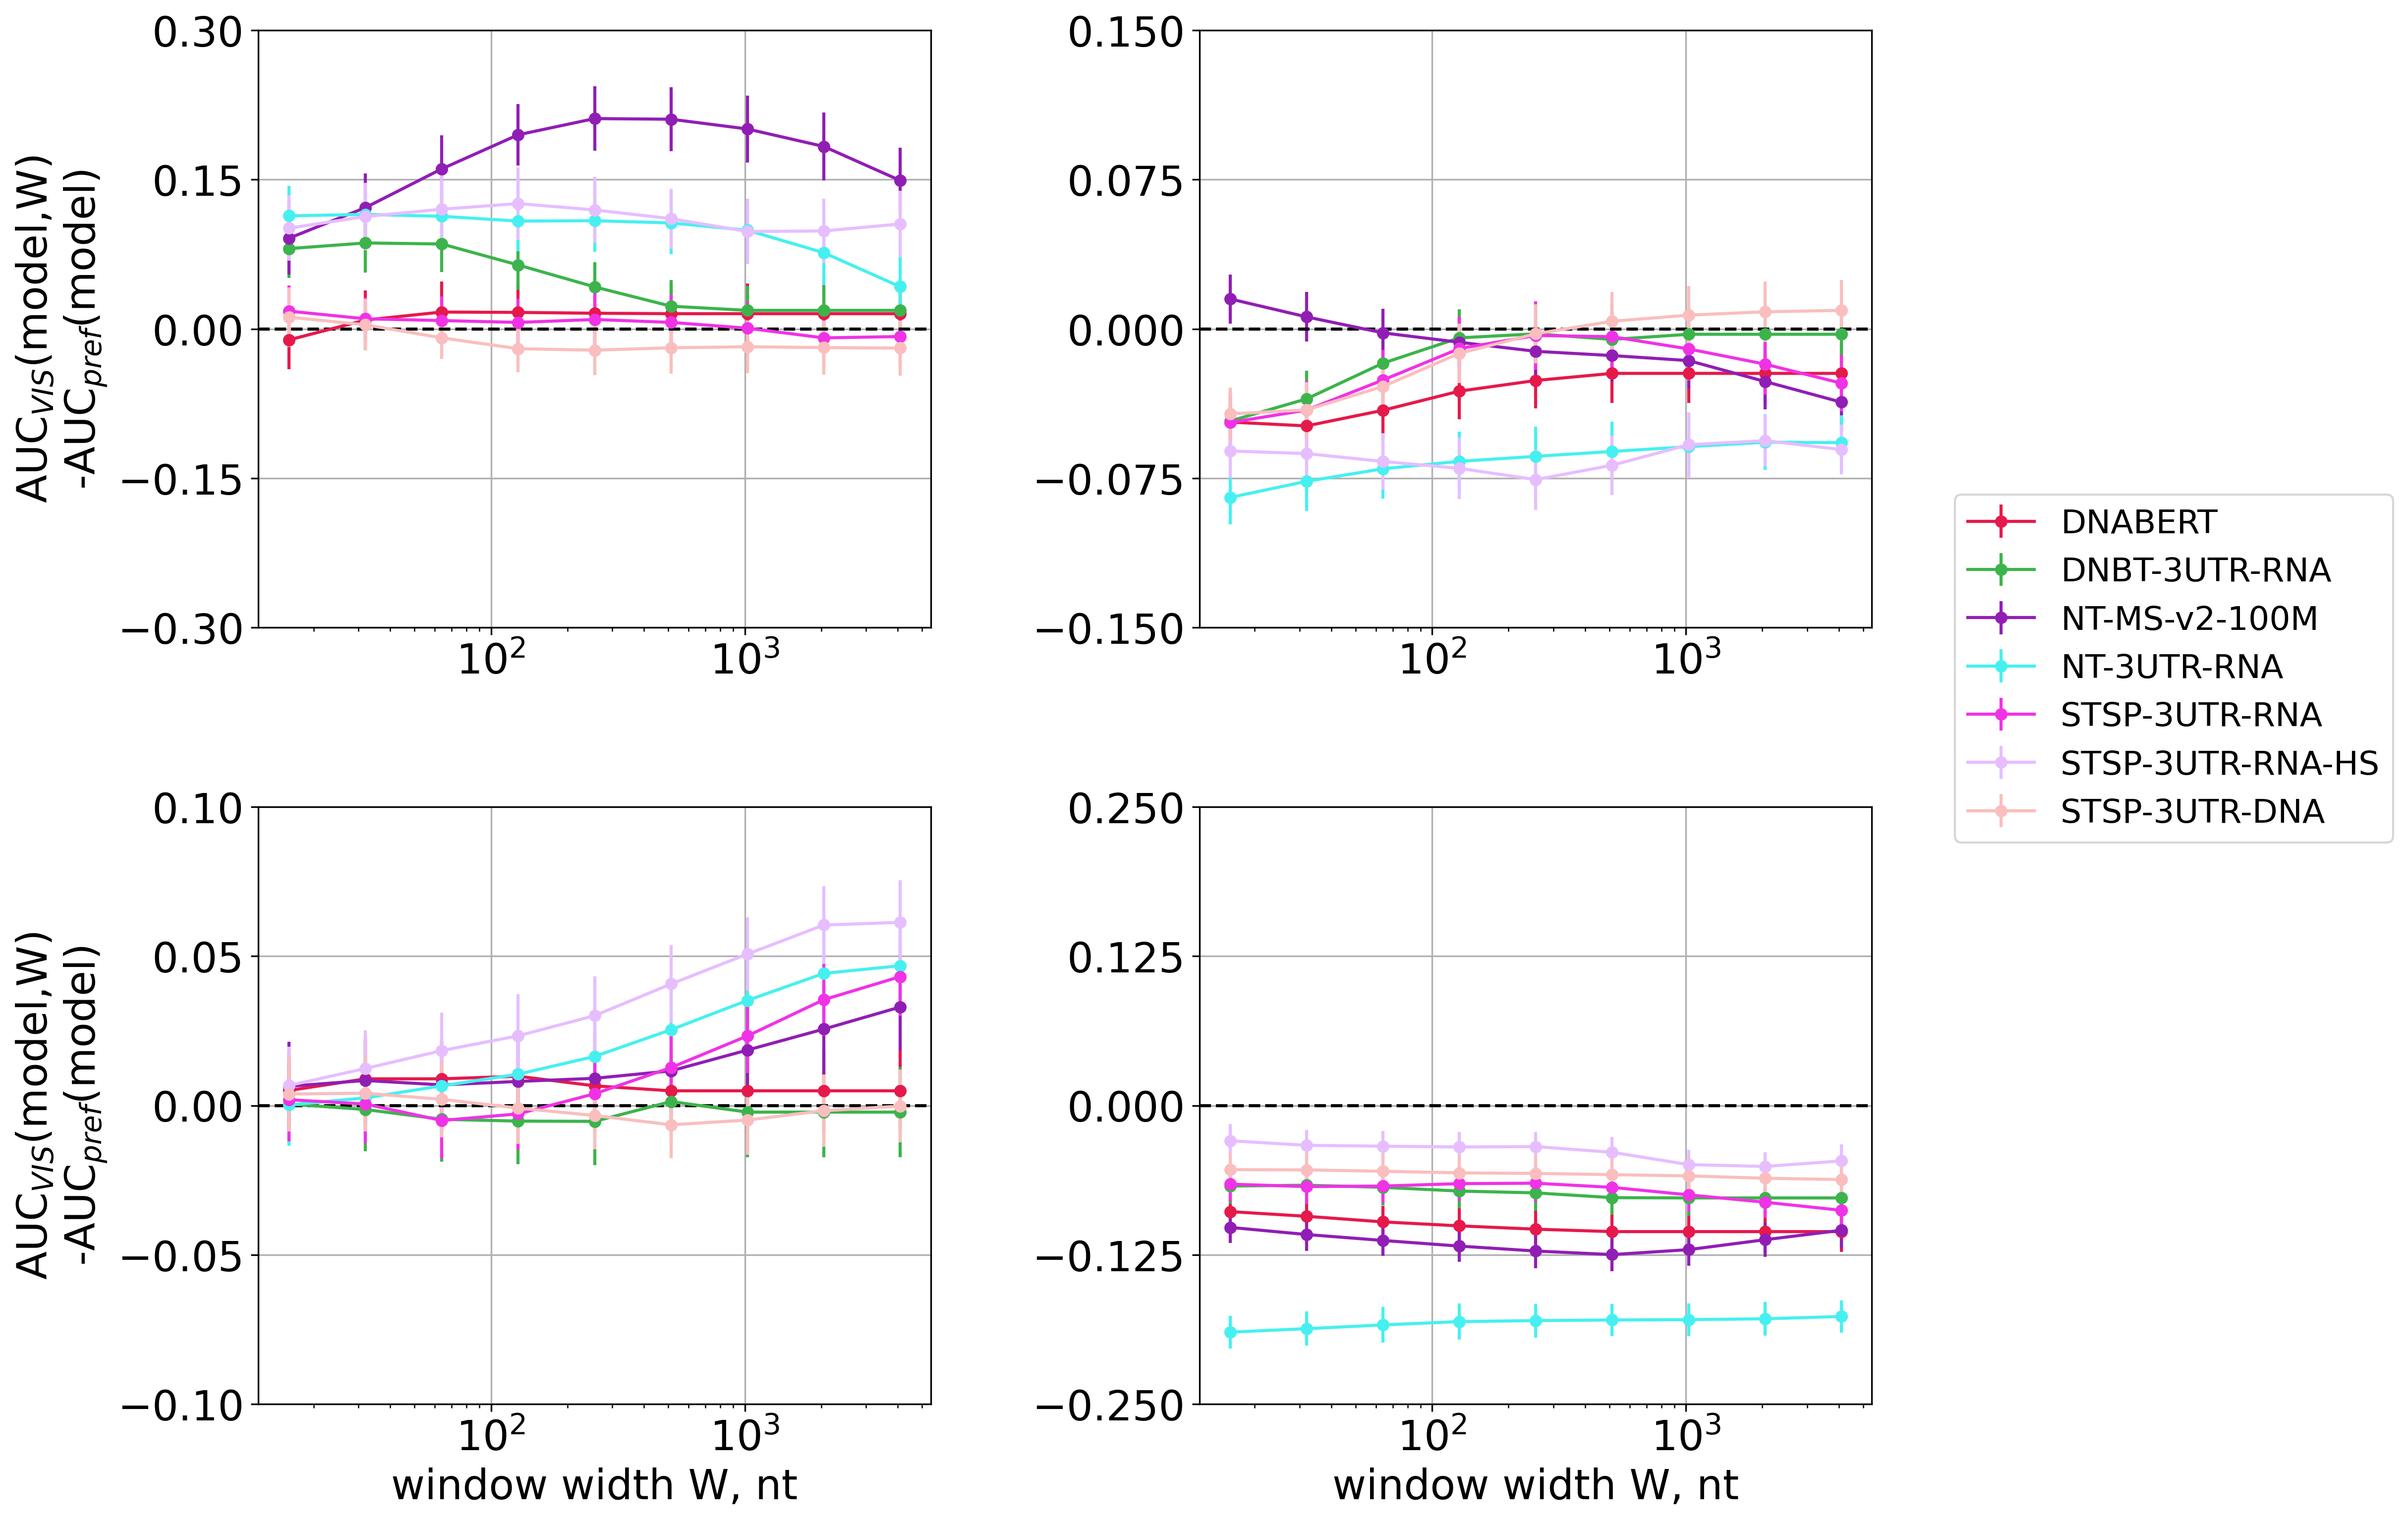

In [20]:
splits = ['clinvar', 'gnomAD', 'eQTL-susie', 'CADD', ]

fig,axes = plt.subplots(2,2, figsize=(14,12),dpi=300)

axes = axes.flatten()

W = [int(x.split('_')[1])*2 for x in vis_scores]

ax_idx = 0

for split, ax in zip(splits,axes):
    for model_name in models:
        vis = res.loc[(split,model_name),vis_scores].dropna()
        W = [int(i.split('_')[1])*2 for i in vis.index]
        vis = vis.values
        auc_pref,auc_pref_err = res.loc[(split,model_name),'pref']
        y,yerr = zip(*vis)
        ax.errorbar(W,y-auc_pref,yerr,color=model_colors[model_name],label=model_name,markersize=10,marker='.')
        #ax.axhline(auc_pref,color=model_colors[model_name], linestyle='--')
        #ax.set_title(split)
    if ax_idx==0 or ax_idx==2:
        ax.set_ylabel('AUC$_{VIS}$(model,W)\n-AUC$_{pref}$(model)')
    if ax_idx==2 or ax_idx==3:
        ax.set_xlabel('window width W, nt')
    if ax_idx==1:
        ax.legend(bbox_to_anchor=(1.8, 0.25),ncol=1, fontsize=16)
        
    ax.grid(True)
    ax.set_xscale('log')
    ax.axhline(0,color='k', linestyle='--')
    
    y_max_abs=abs(np.array(ax.get_ylim())).max()
    y_max = np.ceil(y_max_abs/0.05)*0.05
    ax.set_yticks(np.linspace(-y_max,y_max,5))
    ax.set_ylim([-y_max,y_max])
    
    ax_idx += 1

plt.subplots_adjust(wspace=0.4,hspace=0.3)